# Tutorial for GravothermalSIDM

In [1]:
import os
import glob

from SourcePy.evolve import Halo
from SourcePy.record import HaloRecord
import astropy.units as ut

import matplotlib
import matplotlib.pyplot as plt

## Initialize halo and halo record
Create an instance of the `HaloRecord` class, which handles the file I/O. The instance requires a path (relative or absolute) to a directory in which files generated from the `Halo` class are to be saved. As an example, store the halo data in a subdirectory 'tutorial', which exists within a 'Data' directory.

In [2]:
hrec = HaloRecord('Data/tutorial')

Use the instance of `HaloRecord` to initialize the instance of the `Halo` class, which handles solving the gravothermal evolution equations for the halo. All other inputs and their defaults are explained in the documentation for the `Halo` class.

Creating the instance of `Halo` creates the necessary directory structure (if needed) and saves the initialization file.

In [3]:
hevo = Halo(hrec, flag_hydrostatic_initial=True)

~~~~~ Creating new halo tutorial


## Evolve halo

Evolve the halo with a given (dimensionless) end time and particular frequency for saving halo state pickle files. It should take a couple minutes to run, producing 15 pickle files for these input run parameters.

In [4]:
hevo.evolve_halo(t_end=10, save_frequency_rate=10)

Success: Evolution has reached dimensionless time 10.00002700858109


Once the halo evolution is complete, check the evolution time in Gyr.

In [5]:
hevo.get_dimensionful_quantity('t',ut.Gyr)

np.float64(0.30196833873165563)

With the latest halo state currently loaded, the evolution can be continued.

In [6]:
hevo.evolve_halo(t_end=12, save_frequency_rate=10)

Success: Evolution has reached dimensionless time 12.00005183861561


Load any pickle file to restore the associated halo state. If the given pickle file does not exist, the pickle file that is the closest in time is located and loaded.

In [7]:
hevo.load_halo('time5d991225559579332.pickle')

~~~~~ Recovered pickled halo state for tutorial, with t=5.991225559579332


True

To get a sense for the step size taken in time during the evolution versus how often files are saved, check how many heat conduction steps were taken to get to this particular halo state, and check what the dimensionless time was for the previous solving step.

In [8]:
print(hevo.n_conduction)
print(hevo.t_before)

283249
5.9911862833248195


If the frequency of file saving was not sufficient, gaps can be filled by loading an intermediate halo state and starting the evolution again with a higher file-saving frequency.

In [9]:
hevo.evolve_halo(t_end=6.73,save_frequency_timing=0.02) # t_end roughly corresponds to time of next currently saved file

Success: Evolution has reached dimensionless time 6.730016749551392


Halo states can be loaded based on approximate dimensionless time.

In [10]:
hevo.load_halo(None,time=11.5)

~~~~~ Recovered pickled halo state for tutorial, with t=11.23354674625274


True

Once all the needed halo state pickle files have been generated, combine the information in the existing pickle files to create an archived record in HDF5 format, which is more suitable for long-term preservation and for sharing. Once the archive file is generated, the pickle files are no longer needed to recover halo states.

In [11]:
if not os.path.isfile(hrec.path_archive): # avoid overwriting existing archive
    hrec.create_archive()

In [12]:
for f in glob.glob(os.path.join(hrec.dir_data,'*.pickle')):
    os.remove(f)

In [13]:
hevo.load_halo(None,time=3.2)

~~~~~ Recovered archived halo state for tutorial, with t=2.995626613222693


True

## Plot halo quantities

Plot the halo profile, comparing the initial profile (as well as the original input profile, before any potential initial hydrostatic adjustments) with the final profile.

~~~~~ Recovered archived halo state for tutorial, with t=12.00005183861561
~~~~~ Recovered archived halo state for tutorial, with t=0.0


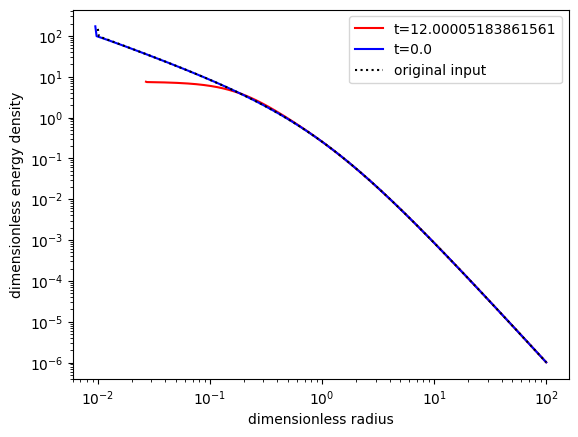

In [14]:
f,ax = plt.subplots()

hevo.load_halo(None,time=None)
ax.plot(hevo.r, hevo.rho, '-r', label='t={}'.format(hevo.t))

hevo.load_halo(None,time=0)
ax.plot(hevo.r, hevo.rho, '-b', label='t={}'.format(hevo.t))

halo_ini_input, original_state = hevo.record.get_halo_initialization()
ax.plot(original_state['r'], original_state['rho'], ':k', label='original input')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('dimensionless radius')
ax.set_ylabel('dimensionless energy density')
ax.legend()

Plot the halo profile using dimensionful units.

~~~~~ Recovered archived halo state for tutorial, with t=12.00005183861561
~~~~~ Recovered archived halo state for tutorial, with t=0.0


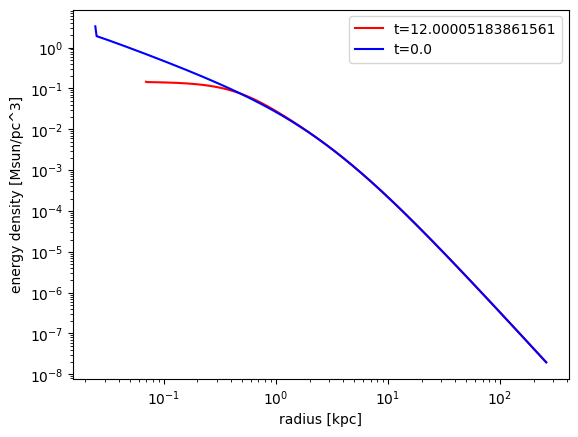

In [15]:
f,ax = plt.subplots()

hevo.load_halo(None,time=None)
radius  = hevo.get_dimensionful_quantity('r',ut.kpc)
density = hevo.get_dimensionful_quantity('rho',ut.M_sun/ut.pc**3)
ax.plot(radius, density, '-r', label='t={}'.format(hevo.t))

hevo.load_halo(None,time=0)
radius  = hevo.get_dimensionful_quantity('r',ut.kpc)
density = hevo.get_dimensionful_quantity('rho',ut.M_sun/ut.pc**3)
ax.plot(radius, density, '-b', label='t={}'.format(hevo.t))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('radius [kpc]')
ax.set_ylabel('energy density [Msun/pc^3]')
ax.legend()

Plot the evolution of the central density. For the evolution of halo properties, it is better to load the full archive table once and slice the data as needed.

Text(0, 0.5, 'rho0 / rho0_init')

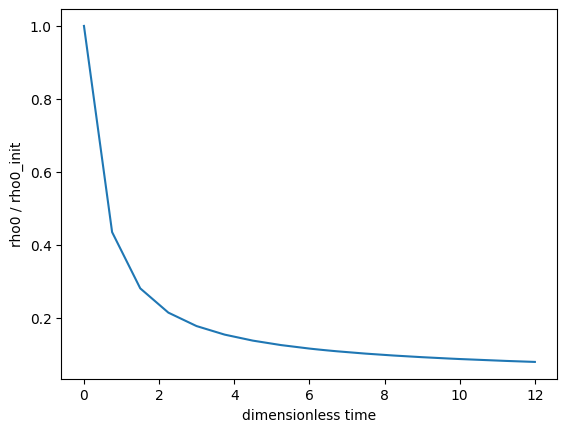

In [16]:
archive = hrec.get_archive()
rho_center = [hevo.get_central_quantity(archive['rho'][i,:]) for i in range(archive['rho'].shape[0])]

f,ax = plt.subplots()
ax.plot(archive['t'],rho_center/rho_center[0])
ax.set_xlabel('dimensionless time')
ax.set_ylabel('rho0 / rho0_init')